## Computation for Dynamic Programming

An important part of applying dynamic programming (in macroeconomics) is learning to do computation. This series of classes shows how I learn to do just that. I use python, and its various tools for efficient computation/optimsition. I start with simple problems and build up complexity. As I do, we will run into computational challenges. Closer to the research frontier, dealing with these challenges becomes the majority of the game. 

This is not intended as an introduction to, nor rigorous mathematical treatment of, dynamic programming. I will often reference *Recursive Methods in Economic Dynamics*, written by Stokey, Lucas, and Prescott---three greats in modern macro! I'll refer to it as SLP and refer the reader to it when I invoke important results/ideas. Despite being well-known for being tough, the explanations of the topic are by far the clearest I have found.  

Mostly, we will consider infinite horizon problems. This is because in finite horizons agents simply go to the "end of time" and, by backwards , unravel the problem. In most contexts, this will be unsatisfactory.

Good luck! I hope you find it reassuring to know that I have struggled through the examples I compute in this series of classes...Unfortunately, this is the only way to learn. 

## Example 1: The Cake-Eating Problem

This is the simplest possible "savings" problem one can pose. Suppose an agent begins life with a cake of size $w_0$ at $t=0$. They then must choose how much of it to consume until they die. That is, the Bellman equation is: 

$$V(w) = \max_{w' \in [0,w]} \bigg\{ u(w-w')+\beta V(w') \bigg\}$$

Notice, I take consumption out of the problem because once tomorrow's cake size is chosen the amount consumed is pinned down (assuming no waste). I will assume $u(c) = \ln(c)$. 

[CITE SOME SLP CONDITIONS]

The steps I follow below are the most basic value function iteration (VFI). I guess the value function "blindly" with $V_0(w)=0$. With a more informed guess computation would be quicker. I then set in motion an iteration. The great thing about VFI is that we have a uniqueness theorem; we know that this numerical procedure will get us arbitrarily close to the unique true value function. For more complex problems, this won't be comforting because computation to get us reasonably close to a solution will be too costly. But we will cross that bridge when we get there...

In this example, the state space is continuous. Over continuous state spaces numerical methods provide an approximation in the sense that we can only compute values at discrete grid points. Another way of saying the same thing: we can only compute a finite number of points! This is a theme we will return to. 

The VFI below shows that in about 30 seconds we can approximate a solution to the problem using pretty tractable code. Moreover, we have an analytical benchmark we can compare the numerical solution to. 

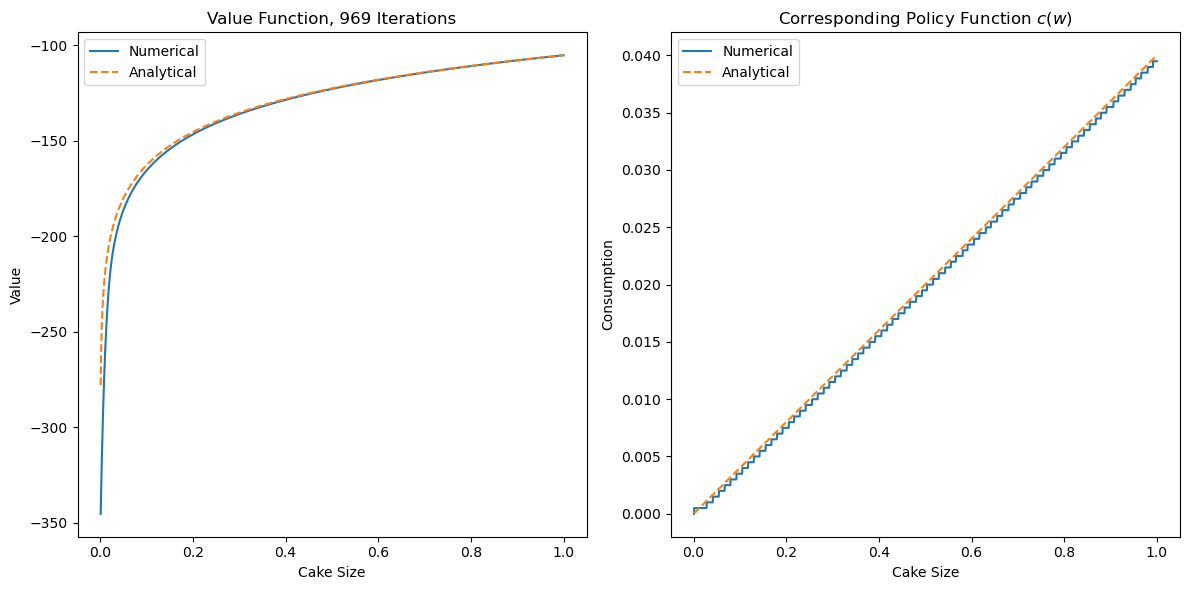

In [77]:
import numpy as np
import matplotlib.pyplot as plt

class CakeEatingModel:
    def __init__(self, grid_size=1000, beta=0.96, cake_size=1.0):
        # choose parameters
        self.grid_size = grid_size
        self.beta = beta
        self.cake_size = cake_size
        
        # discretise the w grid
        self.grid = np.linspace(1e-3, cake_size, grid_size)
        self.U = self._compute_utility_matrix()
        
        # placeholders for outputs
        self.V = None
        self.c = None
        self.iter_count = 0

    # define the consumption function 
    def _utility(self, cons):
        # forbid the use of 0 by using a small pos number 
        cons = np.maximum(cons, 1e-6)
        return np.log(cons)

    # define the utility matrix
    def _compute_utility_matrix(self):
        grid = self.grid
        grid_length = self.grid_size
        
        # create utilities of -infs
        U = np.full((grid_length, grid_length), -np.inf)
        
        # loop over the grid
        for i in range(grid_length):
            # loop over valid parts of the grid (lower triangle)
            for j in range(i + 1):
                # calculate the utility
                U[i, j] = self._utility(grid[i] - grid[j])
        return U

    # define the VFI function
    def solve(self, threshold=1e-16):
        # initialise the error 
        error = 1 + threshold
        # initalise counter
        self.iter_count = 0
        # initialise the value function 
        V_old = np.zeros(self.grid_size)

        # define value function iteration loop
        while error > threshold:
            # calculate RHS of the Bellman equation
            # use np.newaxis to make a 2D row vector to allow broadcasting
            bellman_rhs = self.U + self.beta * V_old[np.newaxis, :]
            
            # calculate the new value function
            # np.max returns maximum value per row
            V_new = np.max(bellman_rhs, axis=1)
            
            # index for next period cake size
            w_next_index = np.argmax(bellman_rhs, axis=1)
            
            # calculate the implied consumption function
            c_new = self.grid - self.grid[w_next_index]
            
            # break if the value function converges
            if np.max(np.abs(V_new - V_old)) < threshold:
                break
            
            # update the value function
            V_old = V_new
            # increase the iteration count
            self.iter_count += 1

        # save outputs
        self.V = V_new
        self.c = c_new
        return self.V, self.c, self.iter_count

    # plot the V(w) and c(w)
    def plot_solve(self):
        value_comp = (1 - self.beta) ** -1 * np.log(self.grid)
        policy_comp = (1 - self.beta) * self.grid
        
        # normalise value function
        i_match = np.argmax(self.grid)  # since w_grid goes from 0 to 1
        offset = self.V[i_match] - value_comp[i_match]  # shift both to agree at end
        V_analytical_shifted = value_comp + offset

        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.grid, self.V, label='Numerical')
        plt.plot(self.grid, V_analytical_shifted, '--', label='Analytical')
        plt.title(f'Value Function, {self.iter_count} Iterations')
        plt.xlabel('Cake Size')
        plt.ylabel('Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.grid, self.c, label='Numerical')
        plt.plot(self.grid, policy_comp, '--', label='Analytical')
        plt.title(r'Corresponding Policy Function $c(w)$')
        plt.xlabel('Cake Size')
        plt.ylabel('Consumption')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # simulate the cake economy
    def simulate(self, T_max):
        if self.c is None:
            raise RuntimeError("Run .solve() before simulating.")

        # store the cake size
        w_sequence = np.zeros(T_max)
        # initial cake size
        current_cake = self.cake_size
        # first period cake size
        w_sequence[0] = current_cake

        # loop over time
        for t in range(1, T_max):
            # find the index of the current cake size
            index = np.searchsorted(self.grid, current_cake)
            # clamp to avoid index errors at edges
            index = min(index, self.grid_size - 1)
            # calculate the consumption
            consumption = self.c[index]
            # calculate the next period cake size
            next_cake = current_cake - consumption
            # store the next cake size
            w_sequence[t] = next_cake
            # update the current cake size
            current_cake = next_cake

        return w_sequence


# initialise
cake_vfi = CakeEatingModel(2000, 0.96,1)
cake_vfi.solve()
cake_vfi.plot_solve()



Because this world is non-stochastic, we can exactly simulate what will happen to the cake over a number of periods. 

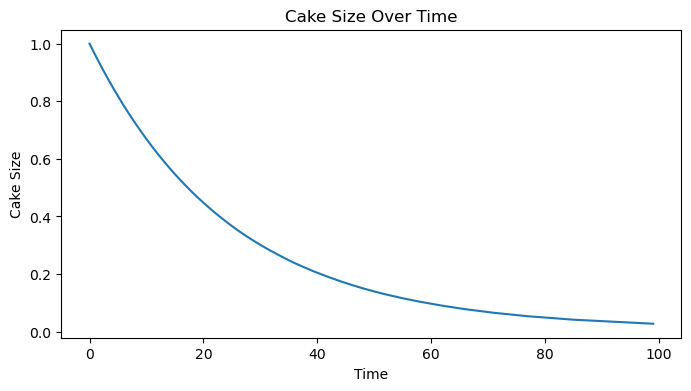

In [78]:
simulation = cake_vfi.simulate(100)

# plot the simulation
plt.figure(figsize=(8, 4))
plt.plot(simulation)
plt.title('Cake Size Over Time')
plt.xlabel('Time')
plt.ylabel('Cake Size')
plt.show()

In this cake eating problem, with the preferences specified, if the agent follow the computed policy function this is how the size of the cake will vary over time. This is pretty cool, with VFI we have made progress on this problem. Now let's push this to a more serious problem.

## Example 2: SP In a One Good Production Economy

Suppose that there is one good $y_t$, which is produced by a unit mass of firms with a production function $y_t = F(k_t)$. That consumption good can be consumed or invested. There is a unit mass of consumers who with utility function $u(c_t), c_t \geq 0$. If invested, the good adds to the capital stock according to $i_t = k_{t+1} - (1-\delta) k_t$. $\delta \in (0,1)$ is the depreciation rate of capital. At the beginning of time, a capital stock $k_0$ is inherited.

This is a classic problem which embeds a similar dilemma to the cake-eating problem. Consume now or invest in production and consume more later. In addition, work more and have a greater supply of the good, at the cost of disliking that extra work. For now, we will pretend that a social planner chooses allocations to maximise consumer utility and does not need to bother about prices or interactions between agents. The goods resource constraint is: $c_t+\underbrace{k_{t+1} - (1-\delta) k_t}_{i_t} = F(k_t)$. For tidyness, $f(k_t) = (1-\delta)k_t+F(k_t)$: the total amount of the good available for consumption and capital investment. Similar to the cake-eating problem, we can remove consumption and investment so that the only choice variable is the amount of capital to have next period for production. The social planner's Bellman equation is: 

$$V(k) = \max_{k' \in [0, f(k)]} \bigg\{ u(f(k)-k') + \beta V(k') \bigg\}$$

This problem satisfies certain conditions, [INSERT SLP], which guarantee that VFI will converge towards the true value function and single-valued, continuous policy function, $k'(k)$.

We will attack the problem identically as the cake-eating problem. We will use the following functional forms:
- $F(k_t)=k_t^{\alpha}, \, \alpha  \in (0,1)$, the standard Cobb-Douglass production function

In this problem, knowing what to set as the grid is trickier. Before, the size of the cake we began with gave us a natural upper bound to discretise the grid. The upper bound for capital is not immediately obvious, even if there is a per period upper bound. By the properties of consumers, we do know that the SP will not simply accumulate/hoard capital. But the SP can accumulate capital stock over time if it is worth expanding the capital stock for future consumption. The way we will set the upper bound is by finding the steady state (SS) capital $k_{ss}$, and setting the upper limit as some reasonable multiple of it.

To find $k_{ss}$, we need the euler equation (EE). I write the partial derivate with a subscript in the variable the partial derivative is taken with respect to. It relies on an Envelope Theorem argument, but since it is easy to forget (I always do!), I will derive it from scratch. It is important and good practice to move between the Bellman equation and EEs anyway. Let $\mathcal{L}(k, k'(k))$ be the value function evaluated at the optimal points. We can take the partial derivative with respect to the control ($k'(k)$). But when taking a derivative with respect to the state $k$, we need to account for the fact that this is will endogeneously change the controls. Remembering what it means to take the total derivative:

$$ \frac{dV(k)}{dk} = \mathcal{L}_{k}(k,k'(k))+\mathcal{L}_{k'}(k,k'(k))k'_k(k)$$

But since $k'(k)$ are at their optimal points, $\mathcal{L}_{k'}(k,k'(k))=0$! Tomorrow's capital is chosen to maximise $\mathcal{L}$.

$$ \frac{dV(k)}{dk} = V_k(k) = \mathcal{L}_{k}(k,k'(k)) = u_c(f(k)-k')f_k(k)$$

Now take the FOC with respect to $k'$. Remember, $\mathcal{L}_k'(k,k'(k))=0$ because $k'$ is a one of the controls. This can be written: 

$$ \mathcal{L}_{k'}(k, k'(k)) = -u_c(f(k)-k')+\beta V_{k'}(k') =0$$

We can combine these two FOCs into one intertemporal equilibrium condition. The double dashes correspond to two periods ahead. The condition is,

$$ u_c(f(k)-k') = \beta u_c(f(k')-k'')f_{k'}(k')$$

Or, plugging in SS values and functional forms, 

$$1 = \beta(1-\delta + \alpha k_{ss}^{\alpha-1})$$

This gives us an analytical expression for the steady state of capital.

$$k_{ss} = \bigg( \frac{\alpha}{\beta^{-1}+\delta-1} \bigg)^{\frac{1}{1-\alpha}}$$



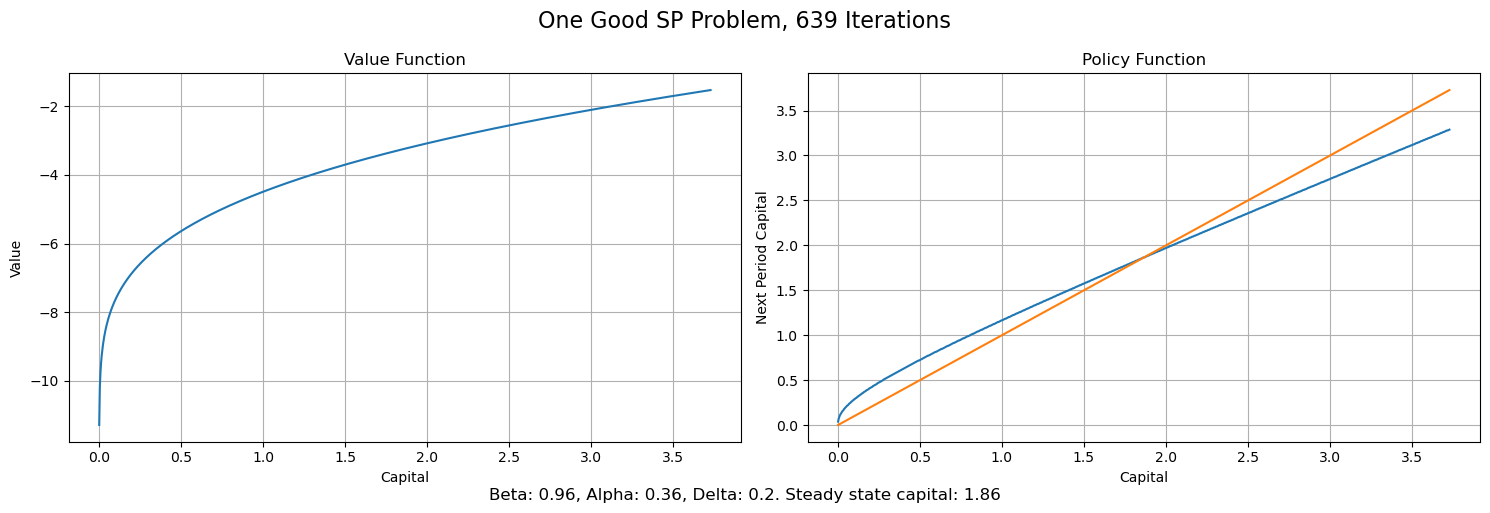

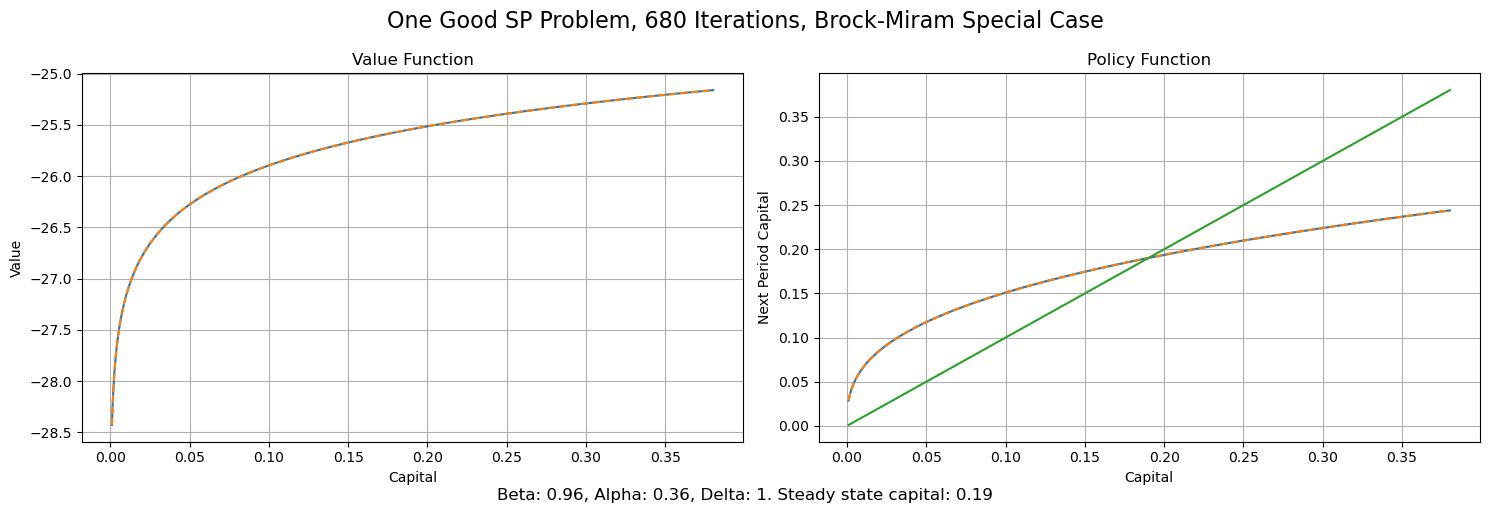

In [202]:
from numba import njit

@njit
def compute_utility_matrix(grid_size, k_grid, alpha, delta):
    # create a 2-D array, i for k, j for k'
    U = np.full((grid_size, grid_size), -1e10)  # Use a larger negative number
    # loop over the capital grid
    for i in range(grid_size):
        # calculate current recources 
        resources = (1-delta) * k_grid[i] + k_grid[i]**alpha
        for j in range(grid_size):
            if k_grid[j] <= resources:
                # calculate the utility
                U[i, j] = np.log(resources - k_grid[j])
            
    return U 
    
    
@njit  
def VFI_OneGood(V_initial, utility_matrix, beta, threshold, grid_size):
    
    # initilise the value funtion loop
    error = 10 + threshold
    V_old = V_initial
    iteration = 0
    V_new = np.zeros(grid_size)
    k_next_index = np.zeros(grid_size, dtype = np.int64)
    
    # do the value function iteration
    while error > threshold:
        # loop over states
        for i in range(grid_size):
            # initialise some values 
            max_value = -10e10
            max_index = 0
            # loop over next states
            for j in range(grid_size):
                # calculate the value
                value = utility_matrix[i, j] + beta * V_old[j]
                # check if the value is larger than the max
                if value > max_value:
                    max_value = value
                    max_index = j
            # assign max value to the value function
            V_new[i] = max_value
            # assign the index of the next state to the policy function index
            k_next_index[i] = max_index
        # check for convergence
        error = np.max(np.abs(V_new - V_old))
        # update the value function
        V_old = V_new.copy()
        # increase the iteration count
        iteration += 1
    # return the value function, policy function index and iteration count    
    return V_new, k_next_index, iteration




# create a class for the one-good with  SP problem
class OneGood_SP:
    def __init__(self, grid_size, capital_grid_multiple, beta=0.96, alpha=0.36, delta=0.1, threshold = 1e-12):
        
        # save parameters
        self.grid_size = grid_size
        self.capital_grid_multiple = capital_grid_multiple
        self.beta = beta
        self.alpha = alpha
        self.delta = delta
        self.threshold = threshold

        # SS capital
        self.k_ss = ( self.alpha / ( beta**(-1)+self.delta - 1) )**(1/(1-self.alpha))

        # create the grid for capital
        self.k_grid = np.linspace(1e-3, capital_grid_multiple*self.k_ss, grid_size)

        # create the utility matrix
        self.U = None

        # initialise the value function 
        self.V_initial = np.zeros(grid_size)

        # placeholders for outputs
        self.V = None
        self.k_next = None
        self.l = None
        self.iterations = None

    # define the VFI solver 
    def solve(self):
        # create the utility matrix
        self.U = compute_utility_matrix(self.grid_size, self.k_grid, self.alpha, self.delta)
        # call on globallly defined VFI function which uses njit
        V_final, k_next_index_final, iteration_final = VFI_OneGood(self.V_initial, self.U, self.beta, self.threshold, self.grid_size)
        # update relevant attributes
        self.V = V_final
        self.k_next = self.k_grid[k_next_index_final]
        self.iterations = iteration_final

    def plot(self):
        
        # initialise the figure of 3 plots
        fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
        # plot the value function
        axs[0].plot(self.k_grid, self.V)
        # if brock-miram plot the analytical value function
        if self.delta == 1:
            # normalise value function
            i_match = np.argmax(self.k_grid)
            value_comp = self.alpha/(1-self.alpha*self.beta) * np.log(self.k_grid)
            offset = self.V[i_match] - value_comp[i_match]  # shift both to agree at end
            V_analytical_shifted = value_comp + offset
            axs[0].plot(self.k_grid, V_analytical_shifted, '--', label='Analytical')
        axs[0].set_title('Value Function')
        axs[0].set_xlabel('Capital')
        axs[0].set_ylabel('Value')
        axs[0].grid()
        
        # plot the policy function
        axs[1].plot(self.k_grid, self.k_next)
        # if brock-miram plot the analytical policy function
        if self.delta == 1:
            axs[1].plot(self.k_grid, self.alpha * self.beta * self.k_grid**self.alpha, '--', label='Analytical')
        # plot the steady state intercept line
        axs[1].plot(self.k_grid, self.k_grid, label='Steady State')
        axs[1].set_title('Policy Function')
        axs[1].set_xlabel('Capital')
        axs[1].set_ylabel('Next Period Capital')
        axs[1].grid()

        # set title
        if self.delta == 1:
            fig.suptitle(f'One Good SP Problem, {self.iterations} Iterations, Brock-Miram Special Case', fontsize=16)
        else: 
            fig.suptitle(f'One Good SP Problem, {self.iterations} Iterations', fontsize=16)
        # subtitle
        fig.text(0.5, 0, f'Beta: {self.beta}, Alpha: {self.alpha}, Delta: {self.delta}. Steady state capital: {self.k_ss:.2f}', ha='center', fontsize=12)
        plt.tight_layout()
        plt.show()
    
# create an instance of the class
one_good = OneGood_SP(1000, 2, 0.96, 0.36, 0.2)
one_good.solve()
one_good.plot()
# create an instance of the class with analytical comparison
one_good_brock = OneGood_SP(1000, 2, 0.96, 0.36, 1)
one_good_brock.solve()
one_good_brock.plot()




How extraordinary! We have computed a solution to a non-trivial economic problem. In fact, because of the equivalence between the social planner problem and the competitive equilibrium, we have actually also solved for the allocation in both cases. This is a point we will come back to. 

The value function has the shape we would expect given the log utility function. However, the 

## Some Computational Reflections (from Ex 1 and Ex 2)

The two simple problems above raise some reflections which will become key as we move to more complex settings.

 1. When we compute the policy functions using discretisations in the way we have, we are imposing that the choice ($w'$ in the cake eating, or $k'$ and $l$ in the one good economy) prescribed by the policy function is on the grid. Given that the  in question are continuous, this will almost never be true. Moreover, this results in the funny "steps" in the cake-eating policy function.
 2. As the control space grows, the space to search for optimal policies grows exponentially.
 3. Grids points are evenly spaced.
